## BENG 227 Final Project
##### Team 5 (Aleysha Chen and Maggie Lin)

### Replicate simplified, diffusion-dependent IP drug delivery model (Rezaeian et al. *Cancers*, 2023)

Running intraperitoneal drug delivery simulation with paper parameters...
Simulation time: 1.00 hours
Diffusion stability parameter: 0.003400
Time: 0.0min, Max drug: 0.006μM, Max kill: 0.000
Time: 10.0min, Max drug: 1.105μM, Max kill: 0.000
Time: 20.0min, Max drug: 1.121μM, Max kill: 0.000
Time: 30.0min, Max drug: 1.136μM, Max kill: 0.000
Time: 40.0min, Max drug: 1.151μM, Max kill: 0.000
Time: 50.0min, Max drug: 1.166μM, Max kill: 0.000
Simulation completed!


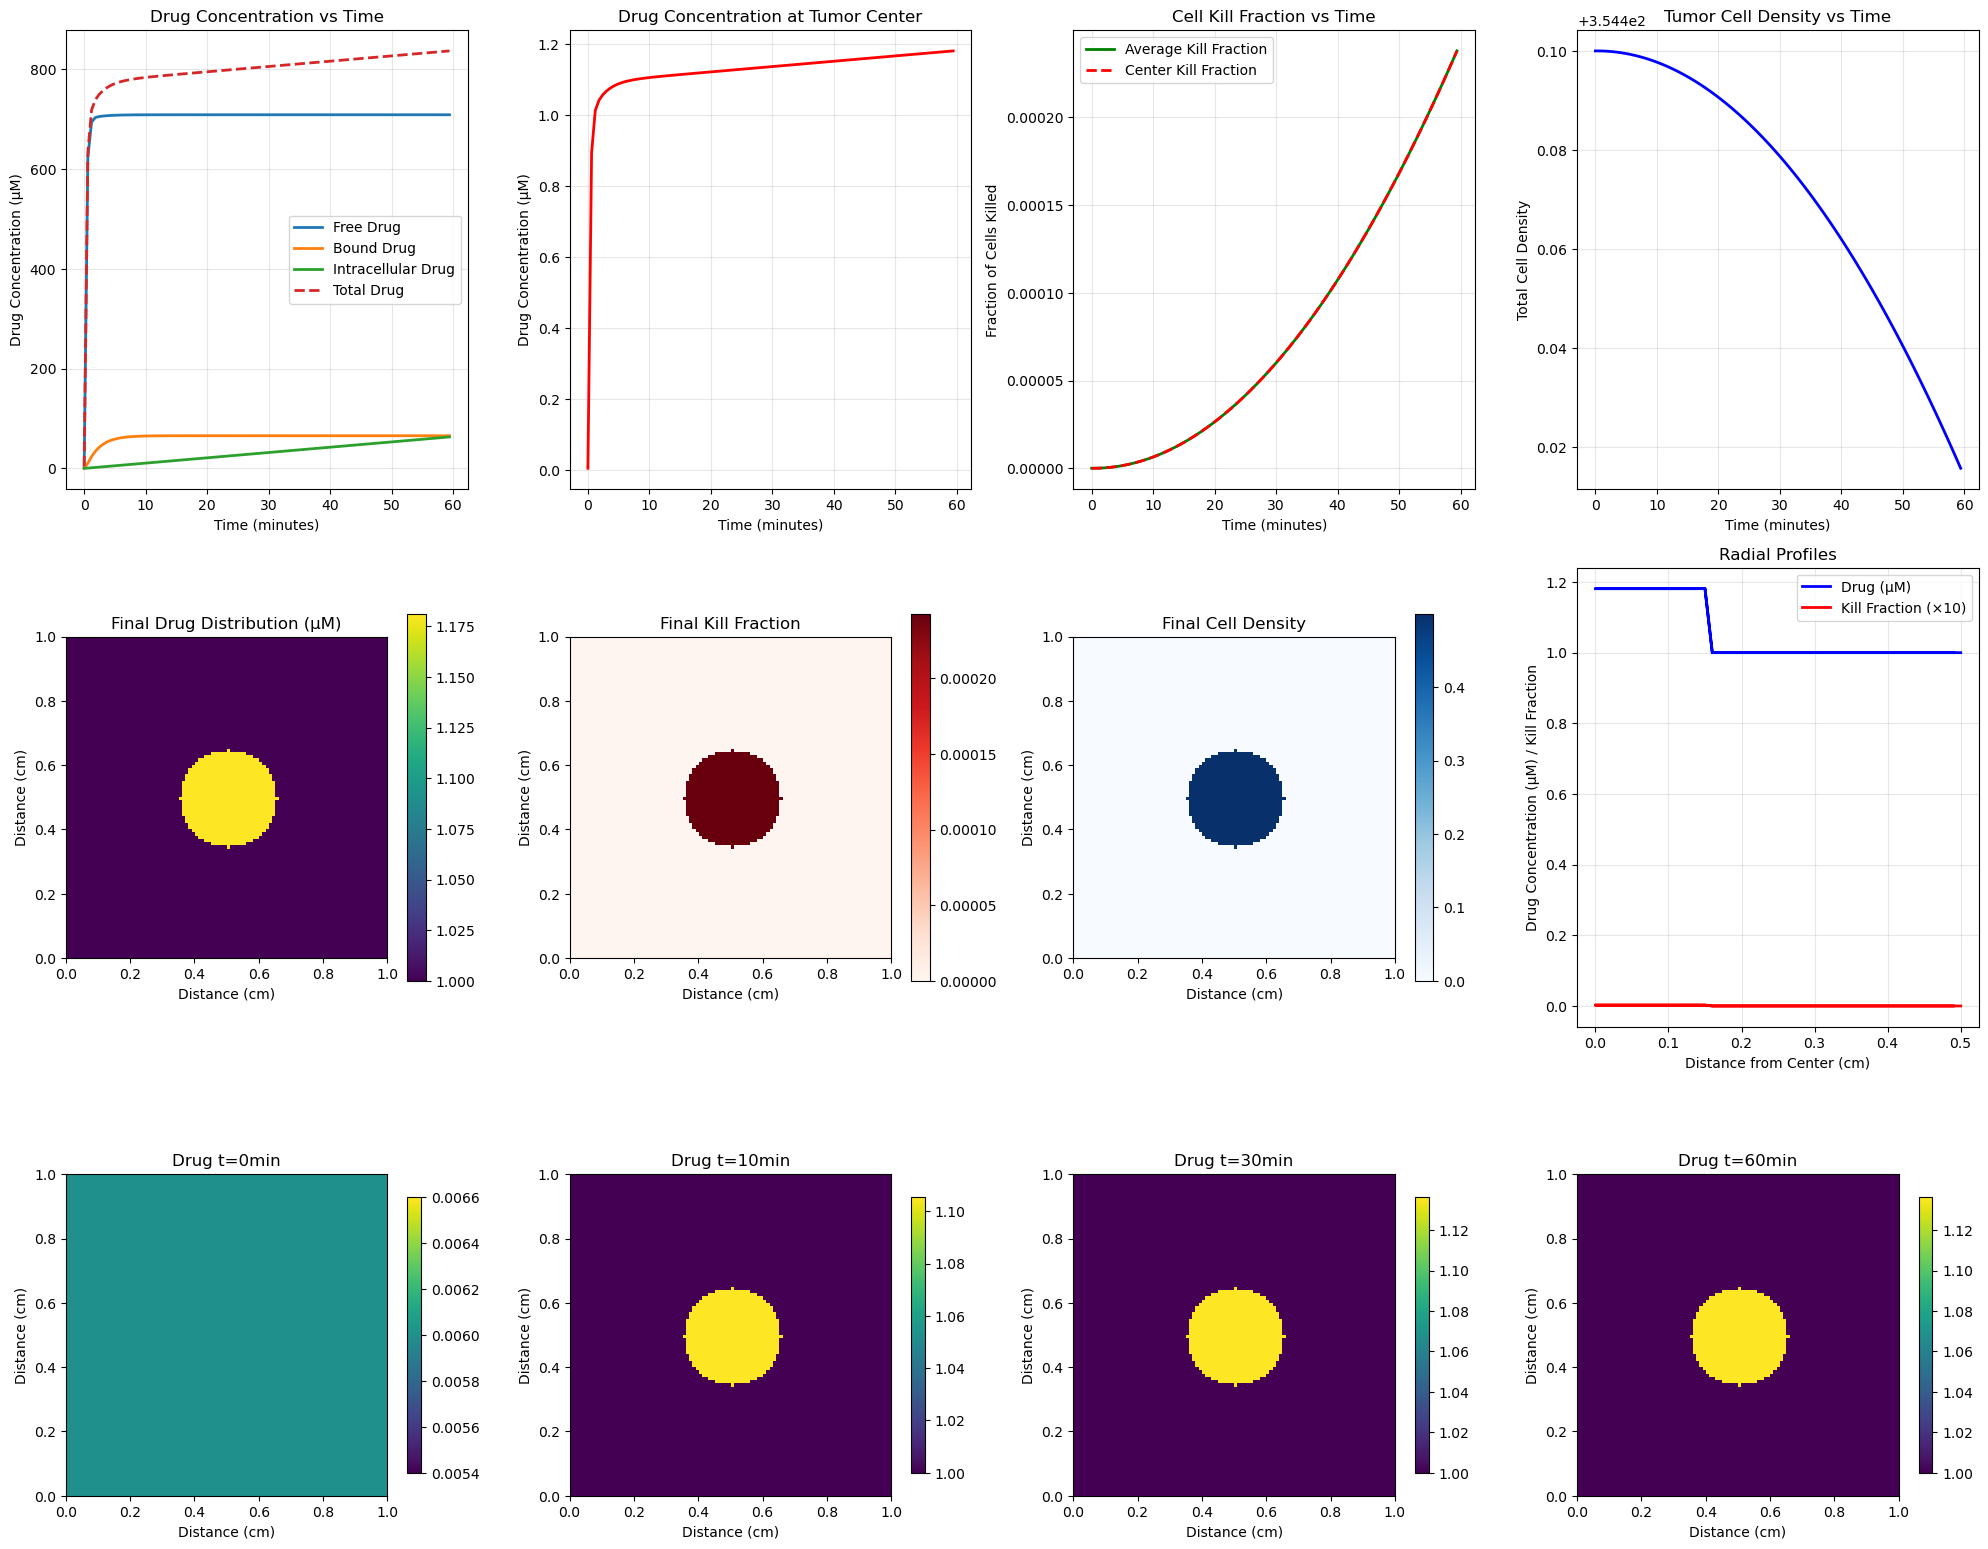

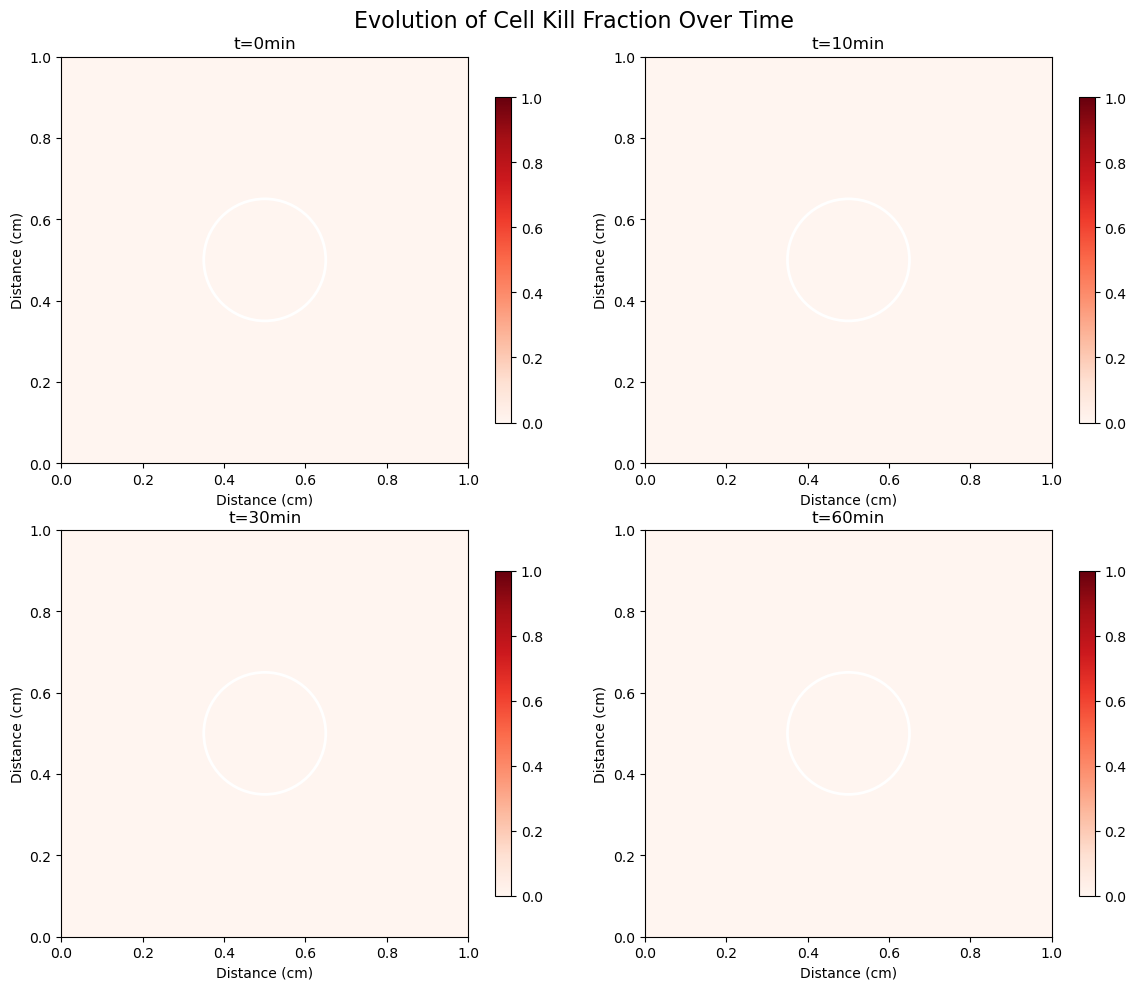


Simulation Summary:
Final average kill fraction: 0.0002
Final center drug concentration: 1.1802 μM
Final total cells: 354.4
Maximum drug concentration: 1.1812 μM
Maximum kill fraction: 0.0002
Simulation completed over 1.00 hours

Parameters used:
S/V: 2.0e+02 cm^-1
σ_s: 0.9
D_eff: 3.40e-06 cm^2/s
P: 3.00e-04 cm/s
K_ON: 1.5e+02 M^-1·s^-1
K_OFF: 8.00e-03 s^-1
K_INT: 5.0e-05 s^-1
φ: 0.3
C_rec: 1.0e-05 M
ω: 660300.0000 cm^3·mol^-1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
grid_size = 100  # Grid dimensions
dx = 0.01        # Spatial resolution (cm)
dt = 0.1         # Time step (seconds)
time_steps = 36000  # Number of time steps for 1 hour (3600 seconds)
total_time = time_steps * dt

# Paper's parameters (converted to appropriate units)
S_V = 2e4 * 1e-2     # Surface area per unit volume (cm^-1) - converted from m^-1
sigma_s = 0.9        # Osmotic reflection coefficient
D_eff = 3.40e-6      # Effective diffusion coefficient (cm^2/s)
P = 3.00e-4          # Microvessel permeability coefficient (cm/s)
K_ON = 1.5e2         # Binding rate constant (M^-1·s^-1)
K_OFF = 8e-3         # Unbinding rate constant (s^-1)
K_INT = 5e-5         # Cell uptake rate constant (s^-1)
phi = 0.3            # Tumor volume fraction accessible to drugs
C_rec = 1e-5         # Concentration of cell surface receptors (M)
omega = 0.6603       # Cancer cell survival constant (m^3·mol^-1)

# Convert omega to appropriate units (cm^3·mol^-1)
omega = omega * 1e6  # m^3 to cm^3

# Additional parameters
C_plasma = 1e-6      # Plasma drug concentration (M) - typical doxorubicin level
initial_cell_density = 0.5  # Initial tumor cell density
tumor_radius = 15    # Tumor radius in grid points
k_max = 1e-3        # max death rate: 0.1% of cells per second
EC50  = 8.306e-6    # EC50 (M) of doxorubicin in MCF7 cells
n     = 1.2        # mild cooperativity

# Tumor parameters
tumor_center = (grid_size//2, grid_size//2)

# Initialize grids
C_free = np.zeros((grid_size, grid_size))      # Free drug concentration (M)
C_bound = np.zeros((grid_size, grid_size))     # Bound drug concentration (M)
C_intracellular = np.zeros((grid_size, grid_size))  # Intracellular drug (M)
cell_density = np.zeros((grid_size, grid_size)) # Cell density (dimensionless)
kill_fraction = np.zeros((grid_size, grid_size)) # Fraction of cells killed

# Initialize tumor
y, x = np.ogrid[:grid_size, :grid_size]
tumor_mask = (x - tumor_center[0])**2 + (y - tumor_center[1])**2 <= tumor_radius**2
cell_density[tumor_mask] = initial_cell_density

# Storage arrays for plotting
time_points = []
total_free_drug = []
total_bound_drug = []
total_intracellular_drug = []
total_cells = []
total_kill_fraction = []
center_drug_conc = []
center_kill_frac = []

# Spatial profiles storage at specific times
spatial_profiles_drug = []
spatial_profiles_kill = []
profile_times = [0, 600, 1800, 3600]  # 0, 10min, 30min, 60min in seconds

def apply_vascular_exchange(C_free, dt):
    """Apply vascular exchange using Starling equation"""
    # Vascular exchange term: P * S/V * (C_plasma - C_free)
    exchange_rate = P * S_V * (C_plasma - C_free)
    C_free += exchange_rate * dt
    return C_free

def diffusion_step(C, D, dt, dx):
    """Apply diffusion using explicit finite difference"""
    # Check stability condition
    alpha = D * dt / dx**2
    if alpha > 0.25:
        print(f"Warning: Diffusion may be unstable (α = {alpha:.4f})")
    
    C_new = C.copy()
    for i in range(1, grid_size-1):
        for j in range(1, grid_size-1):
            # Only apply diffusion in tumor region (accessible volume fraction)
            if tumor_mask[i, j]:
                laplacian = (C[i+1,j] + C[i-1,j] + C[i,j+1] + C[i,j-1] - 4*C[i,j]) / dx**2
                C_new[i,j] += phi * D * laplacian * dt
    return C_new

def binding_kinetics(C_free, C_bound, cell_density, dt):
    """Calculate drug binding/unbinding kinetics"""
    # Available binding sites
    total_receptors = C_rec * cell_density
    occupied_receptors = C_bound
    free_receptors = np.maximum(total_receptors - occupied_receptors, 0)
    
    # Binding and unbinding rates
    binding_rate = K_ON * C_free * free_receptors
    unbinding_rate = K_OFF * C_bound
    
    # Update concentrations
    dC_free_dt = -binding_rate + unbinding_rate
    dC_bound_dt = binding_rate - unbinding_rate
    
    return dC_free_dt, dC_bound_dt

def cell_uptake(C_free, C_intracellular, cell_density, dt):
    """Calculate cellular uptake of drug"""
    uptake_rate = K_INT * C_free * cell_density
    dC_free_dt = -uptake_rate
    dC_intracellular_dt = uptake_rate
    
    return dC_free_dt, dC_intracellular_dt

def cell_kill_calculation(C_intracellular, cell_density, dt):
    """Calculate cell killing based on intracellular drug concentration"""
    # Using the survival constant omega
    # Kill rate proportional to intracellular drug concentration
    C_intra_cm3 = C_intracellular * 1e-3
    kill_rate = C_intra_cm3 / omega
    kill_rate = k_max * (C_intracellular**n) / (EC50**n + C_intracellular**n)
    # kill_rate = C_intracellular / (omega * 1e-6)  # Convert to appropriate units
    
    # Update cell density and kill fraction
    cell_death = kill_rate * cell_density * dt
    
    return cell_death

# Main simulation loop
print("Running intraperitoneal drug delivery simulation with paper parameters...")
print(f"Simulation time: {total_time/3600:.2f} hours")
print(f"Diffusion stability parameter: {D_eff * dt / dx**2:.6f}")

for t in range(time_steps):
    current_time = t * dt
    
    # Vascular exchange (drug delivery from blood vessels)
    C_free = apply_vascular_exchange(C_free, dt)
    
    # Diffusion of free drug
    C_free = diffusion_step(C_free, D_eff, dt, dx)
    
    # Drug binding kinetics
    dC_free_binding, dC_bound_binding = binding_kinetics(C_free, C_bound, cell_density, dt)
    
    # Cell uptake
    dC_free_uptake, dC_intracellular_uptake = cell_uptake(C_free, C_intracellular, cell_density, dt)
    
    # Update drug concentrations
    C_free += (dC_free_binding + dC_free_uptake) * dt
    C_bound += dC_bound_binding * dt
    C_intracellular += dC_intracellular_uptake * dt
    
    # Ensure non-negative concentrations
    C_free = np.clip(C_free, 0, None)
    C_bound = np.clip(C_bound, 0, None)
    C_intracellular = np.clip(C_intracellular, 0, None)
    
    # Cell death calculation
    cell_death = cell_kill_calculation(C_intracellular, cell_density, dt)
    
    # Update cell density and kill fraction
    cell_density -= cell_death
    cell_density = np.clip(cell_density, 0, 1)
    
    # Update cumulative kill fraction
    kill_increment = cell_death / np.maximum(initial_cell_density, 1e-10)
    kill_fraction += kill_increment
    kill_fraction = np.clip(kill_fraction, 0, 1)
    
    # Store data for plotting (every 360 time steps = 36 seconds)
    if t % 360 == 0:
        time_points.append(current_time / 60)  # Convert to minutes
        total_free_drug.append(np.sum(C_free[tumor_mask]) * 1e6)  # Convert to μM
        total_bound_drug.append(np.sum(C_bound[tumor_mask]) * 1e6)
        total_intracellular_drug.append(np.sum(C_intracellular[tumor_mask]) * 1e6)
        total_cells.append(np.sum(cell_density[tumor_mask]))
        avg_kill = np.mean(kill_fraction[tumor_mask]) if np.any(tumor_mask) else 0
        total_kill_fraction.append(avg_kill)
        center_drug_conc.append((C_free[tumor_center] + C_bound[tumor_center] + 
                               C_intracellular[tumor_center]) * 1e6)  # μM
        center_kill_frac.append(kill_fraction[tumor_center])
    
    # Store spatial profiles at specific times
    if current_time in profile_times or abs(current_time - 600) < dt or \
       abs(current_time - 1800) < dt or abs(current_time - 3600) < dt:
        total_drug = (C_free + C_bound + C_intracellular) * 1e6  # Convert to μM
        spatial_profiles_drug.append(total_drug.copy())
        spatial_profiles_kill.append(kill_fraction.copy())
    
    # Print progress every 10 minutes
    if t % 6000 == 0:
        max_drug = np.max((C_free + C_bound + C_intracellular)[tumor_mask]) * 1e6
        max_kill = np.max(kill_fraction[tumor_mask])
        print(f"Time: {current_time/60:.1f}min, Max drug: {max_drug:.3f}μM, Max kill: {max_kill:.3f}")

print("Simulation completed!")

# Create comprehensive plots
fig = plt.figure(figsize=(20, 16))

# Plot 1: Drug concentration over time
plt.subplot(3, 4, 1)
plt.plot(time_points, total_free_drug, label='Free Drug', linewidth=2)
plt.plot(time_points, total_bound_drug, label='Bound Drug', linewidth=2)
plt.plot(time_points, total_intracellular_drug, label='Intracellular Drug', linewidth=2)
total_drug_time = np.array(total_free_drug) + np.array(total_bound_drug) + np.array(total_intracellular_drug)
plt.plot(time_points, total_drug_time, label='Total Drug', linewidth=2, linestyle='--')
plt.xlabel('Time (minutes)')
plt.ylabel('Drug Concentration (μM)')
plt.title('Drug Concentration vs Time')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Center drug concentration over time
plt.subplot(3, 4, 2)
plt.plot(time_points, center_drug_conc, 'r-', linewidth=2)
plt.xlabel('Time (minutes)')
plt.ylabel('Drug Concentration (μM)')
plt.title('Drug Concentration at Tumor Center')
plt.grid(True, alpha=0.3)

# Plot 3: Kill fraction over time
plt.subplot(3, 4, 3)
plt.plot(time_points, total_kill_fraction, 'g-', linewidth=2, label='Average Kill Fraction')
plt.plot(time_points, center_kill_frac, 'r--', linewidth=2, label='Center Kill Fraction')
plt.xlabel('Time (minutes)')
plt.ylabel('Fraction of Cells Killed')
plt.title('Cell Kill Fraction vs Time')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Cell density over time
plt.subplot(3, 4, 4)
plt.plot(time_points, total_cells, 'b-', linewidth=2)
plt.xlabel('Time (minutes)')
plt.ylabel('Total Cell Density')
plt.title('Tumor Cell Density vs Time')
plt.grid(True, alpha=0.3)

# Spatial distribution plots at final time
total_drug_final = (C_free + C_bound + C_intracellular) * 1e6

plt.subplot(3, 4, 5)
im1 = plt.imshow(total_drug_final, cmap='viridis', extent=[0, grid_size*dx, 0, grid_size*dx])
plt.colorbar(im1, shrink=0.8)
plt.title('Final Drug Distribution (μM)')
plt.xlabel('Distance (cm)')
plt.ylabel('Distance (cm)')

plt.subplot(3, 4, 6)
im2 = plt.imshow(kill_fraction, cmap='Reds', extent=[0, grid_size*dx, 0, grid_size*dx])
plt.colorbar(im2, shrink=0.8)
plt.title('Final Kill Fraction')
plt.xlabel('Distance (cm)')
plt.ylabel('Distance (cm)')

plt.subplot(3, 4, 7)
im3 = plt.imshow(cell_density, cmap='Blues', extent=[0, grid_size*dx, 0, grid_size*dx])
plt.colorbar(im3, shrink=0.8)
plt.title('Final Cell Density')
plt.xlabel('Distance (cm)')
plt.ylabel('Distance (cm)')

# Radial profiles
plt.subplot(3, 4, 8)
center_x, center_y = tumor_center
y_indices = np.arange(grid_size)
radial_distances = np.abs(y_indices - center_y) * dx

plt.plot(radial_distances, total_drug_final[center_x, :], 'b-', linewidth=2, label='Drug (μM)')
plt.plot(radial_distances, kill_fraction[center_x, :] * 10, 'r-', linewidth=2, label='Kill Fraction (×10)')
plt.xlabel('Distance from Center (cm)')
plt.ylabel('Drug Concentration (μM) / Kill Fraction')
plt.title('Radial Profiles')
plt.legend()
plt.grid(True, alpha=0.3)

# Time evolution plots
profile_labels = ['t=0min', 't=10min', 't=30min', 't=60min']
for i in range(min(4, len(spatial_profiles_drug))):
    plt.subplot(3, 4, 9 + i)
    im = plt.imshow(spatial_profiles_drug[i], cmap='viridis', 
                   extent=[0, grid_size*dx, 0, grid_size*dx])
    plt.colorbar(im, shrink=0.6)
    plt.title(f'Drug {profile_labels[i]}')
    plt.xlabel('Distance (cm)')
    plt.ylabel('Distance (cm)')

plt.tight_layout()
plt.show()

# Create a separate figure for kill fraction evolution
if len(spatial_profiles_kill) >= 4:
    fig2, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig2.suptitle('Evolution of Cell Kill Fraction Over Time', fontsize=16)
    
    for i in range(4):
        row = i // 2
        col = i % 2
        im = axes[row, col].imshow(spatial_profiles_kill[i], cmap='Reds', 
                                  extent=[0, grid_size*dx, 0, grid_size*dx], 
                                  vmin=0, vmax=1)
        axes[row, col].set_title(f'{profile_labels[i]}')
        axes[row, col].set_xlabel('Distance (cm)')
        axes[row, col].set_ylabel('Distance (cm)')
        plt.colorbar(im, ax=axes[row, col], shrink=0.8)
        
        # Add tumor boundary circle
        circle = plt.Circle((tumor_center[0]*dx, tumor_center[1]*dx), 
                           tumor_radius*dx, fill=False, color='white', linewidth=2)
        axes[row, col].add_patch(circle)
    
    plt.tight_layout()
    plt.show()

print("\nSimulation Summary:")
print(f"Final average kill fraction: {total_kill_fraction[-1]:.4f}")
print(f"Final center drug concentration: {center_drug_conc[-1]:.4f} μM")
print(f"Final total cells: {total_cells[-1]:.1f}")
print(f"Maximum drug concentration: {np.max(total_drug_final):.4f} μM")
print(f"Maximum kill fraction: {np.max(kill_fraction):.4f}")
print(f"Simulation completed over {total_time/3600:.2f} hours")

# Additional analysis
print("\nParameters used:")
print(f"S/V: {S_V:.1e} cm^-1")
print(f"σ_s: {sigma_s}")
print(f"D_eff: {D_eff:.2e} cm^2/s")
print(f"P: {P:.2e} cm/s")
print(f"K_ON: {K_ON:.1e} M^-1·s^-1")
print(f"K_OFF: {K_OFF:.2e} s^-1")
print(f"K_INT: {K_INT:.1e} s^-1")
print(f"φ: {phi}")
print(f"C_rec: {C_rec:.1e} M")
print(f"ω: {omega:.4f} cm^3·mol^-1")

### Improved IP drug devlivery model in heterogenous tumors: Baxter-Jain boundary condition and sensitive/resistant cell subtypes 

Running enhanced intraperitoneal drug delivery simulation...
Cell populations: 70.0% sensitive, 30.0% resistant
Simulation time: 1.00 hours
Baxter-Jain boundary conditions enabled
Time: 0.0min, Max drug: 0.006μM, Max kill (S/R): 0.000/0.000
Time: 10.0min, Max drug: 1.122μM, Max kill (S/R): 0.000/0.000
Time: 20.0min, Max drug: 1.156μM, Max kill (S/R): 0.000/0.000
Time: 30.0min, Max drug: 1.188μM, Max kill (S/R): 0.000/0.000
Time: 40.0min, Max drug: 1.221μM, Max kill (S/R): 0.000/0.000
Time: 50.0min, Max drug: 1.254μM, Max kill (S/R): 0.000/0.000
Simulation completed!


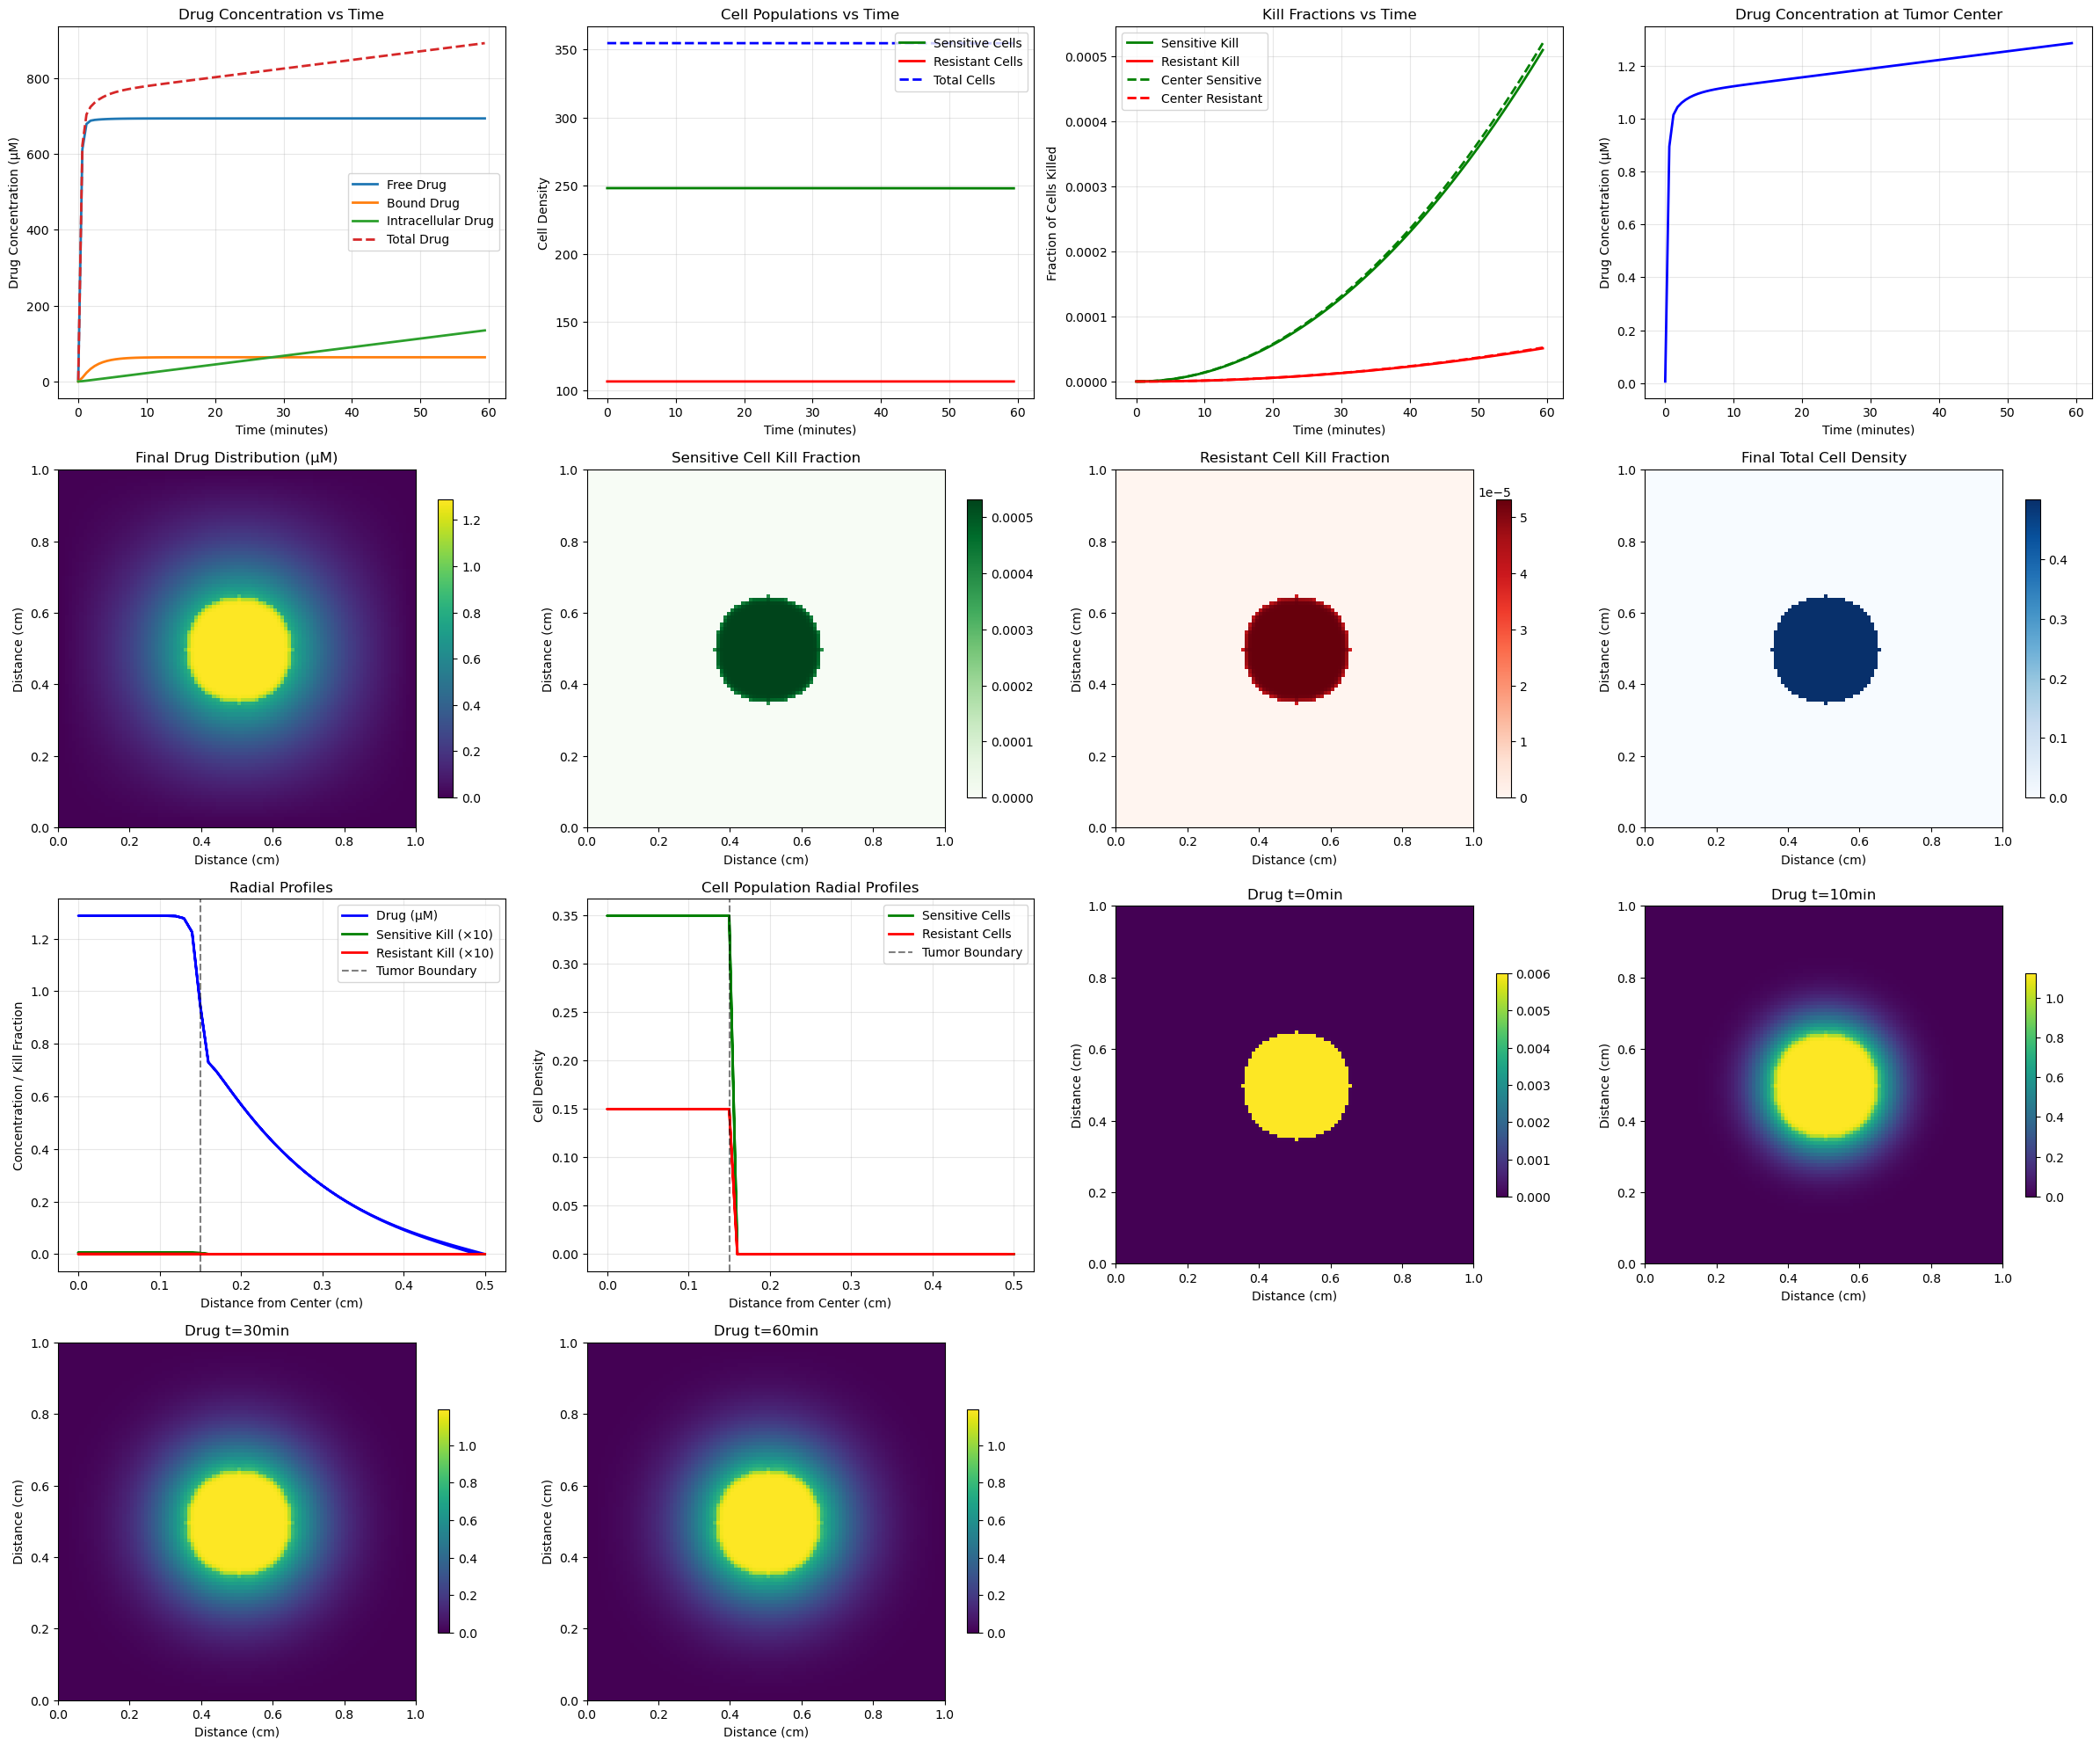

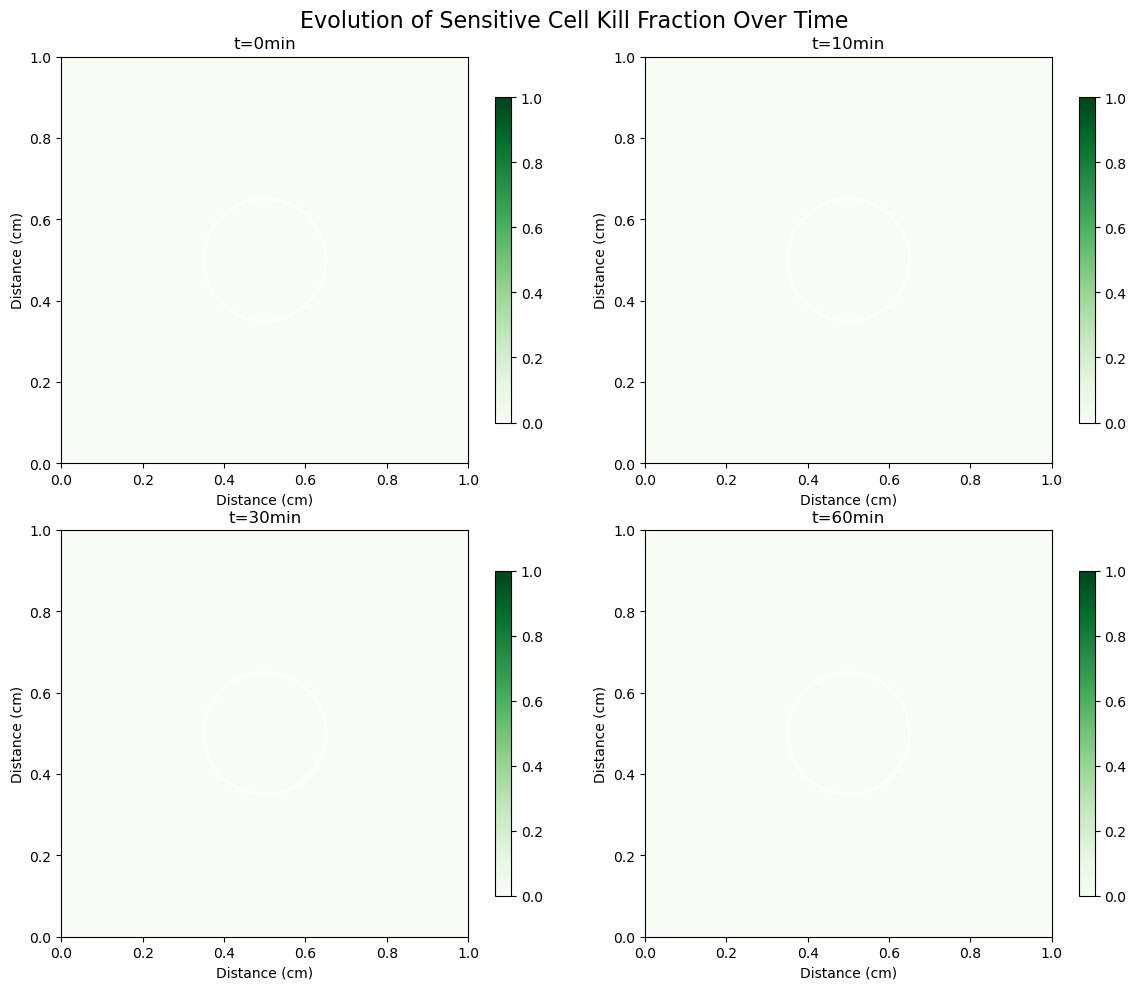

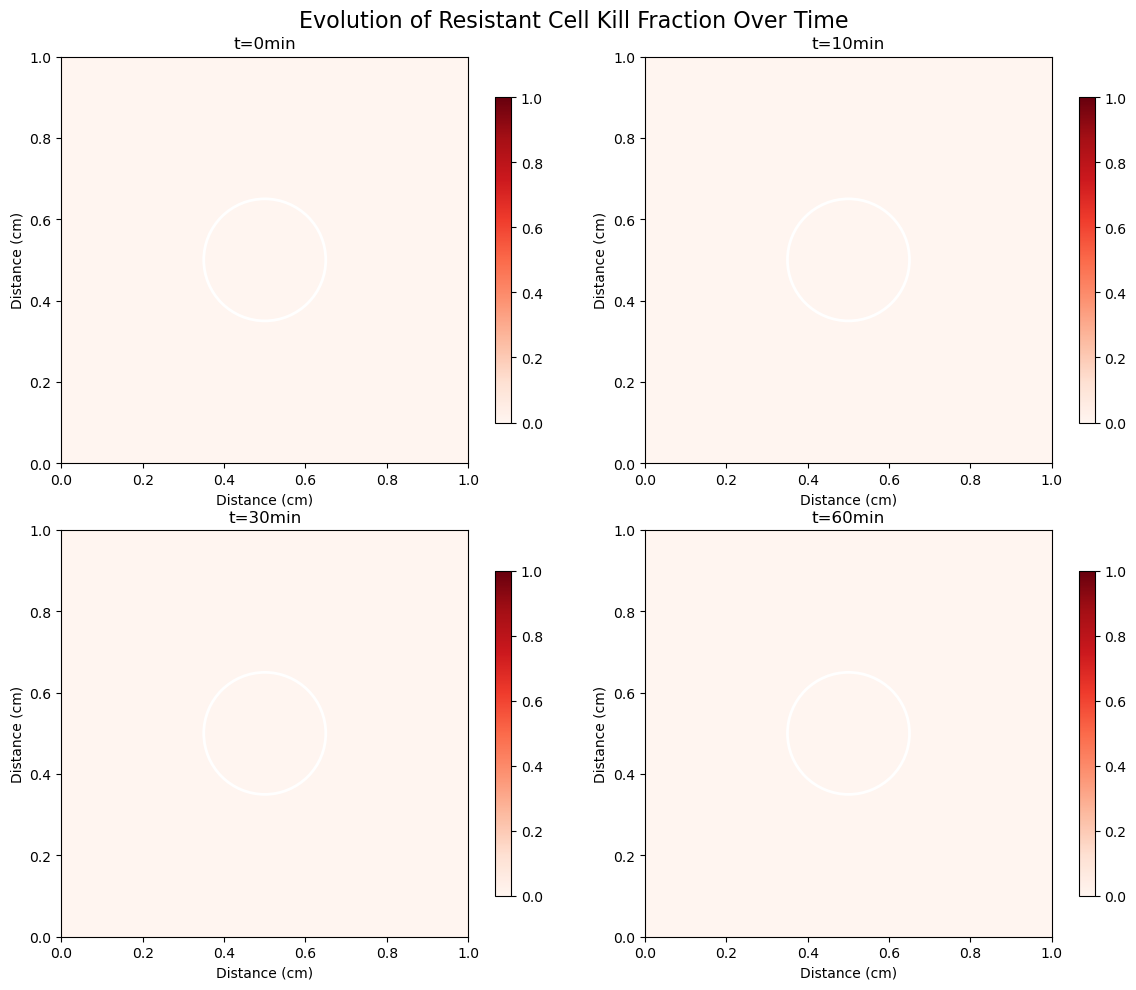


Simulation Summary:
Final sensitive cell kill fraction: 0.0005
Final resistant cell kill fraction: 0.0001
Final center drug concentration: 1.2849 μM
Final sensitive cells: 248.0
Final resistant cells: 106.3
Maximum drug concentration: 1.2869 μM
Maximum sensitive kill fraction: 0.0005
Maximum resistant kill fraction: 0.0001
Simulation completed over 1.00 hours

Enhanced Model Parameters:
Cell populations: 70.0% sensitive, 30.0% resistant
K_INT_sensitive: 1.5e-04 s^-1
K_INT_resistant: 1.5e-05 s^-1
ω_sensitive: 660300.0000 cm^3·mol^-1
ω_resistant: 6603000.0000 cm^3·mol^-1
D_normal: 6.80e-06 cm^2/s
φ_normal: 0.8

Baxter-Jain boundary conditions implemented for tumor-normal tissue interface


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Simulation parameters
grid_size = 100  # Grid dimensions
dx = 0.01        # Spatial resolution (cm)
dt = 0.1         # Time step (seconds)
time_steps = 36000  # Number of time steps for 1 hour (3600 seconds)
total_time = time_steps * dt

# Paper's parameters (converted to appropriate units)
S_V = 2e4 * 1e-2     # Surface area per unit volume (cm^-1) - converted from m^-1
sigma_s = 0.9        # Osmotic reflection coefficient
D_eff = 3.40e-6      # Effective diffusion coefficient (cm^2/s)
P = 3.00e-4          # Microvessel permeability coefficient (cm/s)
K_ON = 1.5e2         # Binding rate constant (M^-1·s^-1)
K_OFF = 8e-3         # Unbinding rate constant (s^-1)
K_INT = 5e-5         # Cell uptake rate constant (s^-1)
phi = 0.3            # Tumor volume fraction accessible to drugs
C_rec = 1e-5         # Concentration of cell surface receptors (M)
omega = 0.6603       # Cancer cell survival constant (m^3·mol^-1)

# Convert omega to appropriate units (cm^3·mol^-1)
omega = omega * 1e6  # m^3 to cm^3

# Additional parameters
C_plasma = 1e-6      # Plasma drug concentration (M) - typical doxorubicin level
initial_cell_density = 0.5  # Initial tumor cell density
tumor_radius = 15    # Tumor radius in grid points

# Baxter-Jain boundary condition parameters
D_normal = D_eff * 2.0   # Diffusivity in normal tissue (typically higher)
phi_normal = 0.8         # Volume fraction in normal tissue (higher than tumor)

# Cell heterogeneity parameters
sensitive_fraction = 0.7  # Fraction of cells that are sensitive
resistant_fraction = 0.3  # Fraction of cells that are resistant
# Different response parameters for sensitive vs resistant cells
K_INT_sensitive = K_INT * 3.0     # Sensitive cells uptake drug faster
K_INT_resistant = K_INT * 0.3     # Resistant cells uptake drug slower
omega_sensitive = omega           # Sensitive cells die easier
omega_resistant = omega * 10.0    # Resistant cells are harder to kill

# Tumor parameters
tumor_center = (grid_size//2, grid_size//2)

# Initialize grids
C_free = np.zeros((grid_size, grid_size))      # Free drug concentration (M)
C_bound = np.zeros((grid_size, grid_size))     # Bound drug concentration (M)
C_intracellular = np.zeros((grid_size, grid_size))  # Intracellular drug (M)

# Cell populations - separate tracking for sensitive and resistant cells
cell_density_sensitive = np.zeros((grid_size, grid_size))
cell_density_resistant = np.zeros((grid_size, grid_size))
kill_fraction_sensitive = np.zeros((grid_size, grid_size))
kill_fraction_resistant = np.zeros((grid_size, grid_size))

# Initialize tumor with mixed cell populations
y, x = np.ogrid[:grid_size, :grid_size]
tumor_mask = (x - tumor_center[0])**2 + (y - tumor_center[1])**2 <= tumor_radius**2
cell_density_sensitive[tumor_mask] = initial_cell_density * sensitive_fraction
cell_density_resistant[tumor_mask] = initial_cell_density * resistant_fraction

# Create masks for tumor boundary and normal tissue
tumor_boundary_mask = np.zeros((grid_size, grid_size), dtype=bool)
normal_tissue_mask = np.zeros((grid_size, grid_size), dtype=bool)

# Define tumor boundary (one layer outside tumor)
for i in range(grid_size):
    for j in range(grid_size):
        dist_to_center = np.sqrt((i - tumor_center[0])**2 + (j - tumor_center[1])**2)
        if tumor_radius < dist_to_center <= tumor_radius + 2:
            tumor_boundary_mask[i, j] = True
        if dist_to_center > tumor_radius + 2:
            normal_tissue_mask[i, j] = True

# Storage arrays for plotting
time_points = []
total_free_drug = []
total_bound_drug = []
total_intracellular_drug = []
total_cells_sensitive = []
total_cells_resistant = []
total_kill_fraction_sensitive = []
total_kill_fraction_resistant = []
center_drug_conc = []
center_kill_frac_sensitive = []
center_kill_frac_resistant = []

# Spatial profiles storage at specific times
spatial_profiles_drug = []
spatial_profiles_kill_sensitive = []
spatial_profiles_kill_resistant = []
profile_times = [0, 600, 1800, 3600]  # 0, 10min, 30min, 60min in seconds

def apply_vascular_exchange(C_free, dt):
    """Apply vascular exchange using Starling equation"""
    # Vascular exchange term: P * S/V * (C_plasma - C_free)
    # Only apply in tumor region
    exchange_rate = np.zeros_like(C_free)
    exchange_rate[tumor_mask] = P * S_V * (C_plasma - C_free[tumor_mask])
    C_free += exchange_rate * dt
    return C_free

def diffusion_step_with_baxter_jain(C, dt, dx):
    """Apply diffusion with Baxter-Jain boundary conditions using implicit method"""
    # Create coefficient matrix for implicit diffusion
    n = grid_size * grid_size
    C_flat = C.flatten()
    
    # Main diagonal coefficients
    main_diag = np.ones(n)
    upper_diag = np.zeros(n-1)
    lower_diag = np.zeros(n-1)
    upper_grid_diag = np.zeros(n-grid_size)
    lower_grid_diag = np.zeros(n-grid_size)
    
    alpha_tumor = phi * D_eff * dt / (dx**2)
    alpha_normal = phi_normal * D_normal * dt / (dx**2)
    
    for i in range(grid_size):
        for j in range(grid_size):
            idx = i * grid_size + j
            
            # Determine local diffusivity and porosity
            if tumor_mask[i, j]:
                alpha = alpha_tumor
            else:
                alpha = alpha_normal
            
            # Interior points
            if 0 < i < grid_size-1 and 0 < j < grid_size-1:
                main_diag[idx] = 1 + 4 * alpha
                
                # Horizontal neighbors
                if j > 0:
                    lower_diag[idx-1] = -alpha
                if j < grid_size-1:
                    upper_diag[idx] = -alpha
                
                # Vertical neighbors
                if i > 0:
                    lower_grid_diag[idx-grid_size] = -alpha
                if i < grid_size-1:
                    upper_grid_diag[idx] = -alpha
                    
                # Special handling for tumor-normal tissue boundary (Baxter-Jain)
                neighbors = [(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
                for ni, nj in neighbors:
                    if 0 <= ni < grid_size and 0 <= nj < grid_size:
                        # Check if crossing tumor boundary
                        if tumor_mask[i,j] and not tumor_mask[ni,nj]:
                            # Tumor to normal tissue - adjust coefficient
                            # Continuity of concentration and flux
                            neighbor_idx = ni * grid_size + nj
                            flux_ratio = (phi * D_eff) / (phi_normal * D_normal)
                            # Modify coefficients to ensure flux continuity
                            if ni == i-1:  # upper neighbor
                                lower_grid_diag[idx-grid_size] *= flux_ratio
                            elif ni == i+1:  # lower neighbor  
                                upper_grid_diag[idx] *= flux_ratio
                            elif nj == j-1:  # left neighbor
                                lower_diag[idx-1] *= flux_ratio
                            elif nj == j+1:  # right neighbor
                                upper_diag[idx] *= flux_ratio
            
            # Boundary conditions
            else:
                main_diag[idx] = 1  # No-flux or specified boundary
    
    # Create sparse matrix
    A = diags([lower_grid_diag, lower_diag, main_diag, upper_diag, upper_grid_diag],
              [-grid_size, -1, 0, 1, grid_size], shape=(n, n), format='csr')
    
    # Solve the system
    try:
        C_new_flat = spsolve(A, C_flat)
        C_new = C_new_flat.reshape((grid_size, grid_size))
    except:
        # Fallback to explicit method if implicit fails
        print("Warning: Implicit diffusion failed, using explicit method")
        C_new = diffusion_step_explicit(C, dt, dx)
    
    return C_new

def diffusion_step_explicit(C, dt, dx):
    """Fallback explicit diffusion method"""
    C_new = C.copy()
    alpha_tumor = phi * D_eff * dt / (dx**2)
    alpha_normal = phi_normal * D_normal * dt / (dx**2)
    
    for i in range(1, grid_size-1):
        for j in range(1, grid_size-1):
            if tumor_mask[i, j]:
                alpha = alpha_tumor
            else:
                alpha = alpha_normal
                
            if alpha <= 0.25:  # Stability check
                laplacian = (C[i+1,j] + C[i-1,j] + C[i,j+1] + C[i,j-1] - 4*C[i,j]) / dx**2
                C_new[i,j] += alpha * dx**2 * laplacian
    
    return C_new

def binding_kinetics(C_free, C_bound, cell_density_sensitive, cell_density_resistant, dt):
    """Calculate drug binding/unbinding kinetics for mixed cell populations"""
    # Total cell density
    total_cell_density = cell_density_sensitive + cell_density_resistant
    
    # Available binding sites (assuming same receptor density for both cell types)
    total_receptors = C_rec * total_cell_density
    occupied_receptors = C_bound
    free_receptors = np.maximum(total_receptors - occupied_receptors, 0)
    
    # Binding and unbinding rates
    binding_rate = K_ON * C_free * free_receptors
    unbinding_rate = K_OFF * C_bound
    
    # Update concentrations
    dC_free_dt = -binding_rate + unbinding_rate
    dC_bound_dt = binding_rate - unbinding_rate
    
    return dC_free_dt, dC_bound_dt

def cell_uptake_heterogeneous(C_free, C_intracellular, cell_density_sensitive, 
                             cell_density_resistant, dt):
    """Calculate cellular uptake for sensitive and resistant cell populations"""
    # Different uptake rates for different cell types
    uptake_rate_sensitive = K_INT_sensitive * C_free * cell_density_sensitive
    uptake_rate_resistant = K_INT_resistant * C_free * cell_density_resistant
    total_uptake_rate = uptake_rate_sensitive + uptake_rate_resistant
    
    dC_free_dt = -total_uptake_rate
    dC_intracellular_dt = total_uptake_rate
    
    return dC_free_dt, dC_intracellular_dt

def cell_kill_calculation_heterogeneous(C_intracellular, cell_density_sensitive, 
                                       cell_density_resistant, dt):
    """Calculate cell killing for sensitive and resistant populations"""
    # Different kill rates for different cell types
    kill_rate_sensitive = C_intracellular / (omega_sensitive * 1e-6)
    kill_rate_resistant = C_intracellular / (omega_resistant * 1e-6)
    
    # Update cell densities
    cell_death_sensitive = kill_rate_sensitive * cell_density_sensitive * dt
    cell_death_resistant = kill_rate_resistant * cell_density_resistant * dt
    
    return cell_death_sensitive, cell_death_resistant

# Main simulation loop
print("Running enhanced intraperitoneal drug delivery simulation...")
print(f"Cell populations: {sensitive_fraction:.1%} sensitive, {resistant_fraction:.1%} resistant")
print(f"Simulation time: {total_time/3600:.2f} hours")
print(f"Baxter-Jain boundary conditions enabled")

for t in range(time_steps):
    current_time = t * dt
    
    # Vascular exchange (drug delivery from blood vessels)
    C_free = apply_vascular_exchange(C_free, dt)
    
    # Diffusion with Baxter-Jain boundary conditions
    C_free = diffusion_step_with_baxter_jain(C_free, dt, dx)
    
    # Drug binding kinetics
    dC_free_binding, dC_bound_binding = binding_kinetics(C_free, C_bound, 
                                                        cell_density_sensitive, 
                                                        cell_density_resistant, dt)
    
    # Cell uptake (heterogeneous)
    dC_free_uptake, dC_intracellular_uptake = cell_uptake_heterogeneous(
        C_free, C_intracellular, cell_density_sensitive, cell_density_resistant, dt)
    
    # Update drug concentrations
    C_free += (dC_free_binding + dC_free_uptake) * dt
    C_bound += dC_bound_binding * dt
    C_intracellular += dC_intracellular_uptake * dt
    
    # Ensure non-negative concentrations
    C_free = np.clip(C_free, 0, None)
    C_bound = np.clip(C_bound, 0, None)
    C_intracellular = np.clip(C_intracellular, 0, None)
    
    # Cell death calculation (heterogeneous)
    cell_death_sensitive, cell_death_resistant = cell_kill_calculation_heterogeneous(
        C_intracellular, cell_density_sensitive, cell_density_resistant, dt)
    
    # Update cell densities
    cell_density_sensitive -= cell_death_sensitive
    cell_density_resistant -= cell_death_resistant
    cell_density_sensitive = np.clip(cell_density_sensitive, 0, 1)
    cell_density_resistant = np.clip(cell_density_resistant, 0, 1)
    
    # Update cumulative kill fractions
    kill_increment_sensitive = cell_death_sensitive / np.maximum(
        initial_cell_density * sensitive_fraction, 1e-10)
    kill_increment_resistant = cell_death_resistant / np.maximum(
        initial_cell_density * resistant_fraction, 1e-10)
    
    kill_fraction_sensitive += kill_increment_sensitive
    kill_fraction_resistant += kill_increment_resistant
    kill_fraction_sensitive = np.clip(kill_fraction_sensitive, 0, 1)
    kill_fraction_resistant = np.clip(kill_fraction_resistant, 0, 1)
    
    # Store data for plotting (every 360 time steps = 36 seconds)
    if t % 360 == 0:
        time_points.append(current_time / 60)  # Convert to minutes
        total_free_drug.append(np.sum(C_free[tumor_mask]) * 1e6)  # Convert to μM
        total_bound_drug.append(np.sum(C_bound[tumor_mask]) * 1e6)
        total_intracellular_drug.append(np.sum(C_intracellular[tumor_mask]) * 1e6)
        total_cells_sensitive.append(np.sum(cell_density_sensitive[tumor_mask]))
        total_cells_resistant.append(np.sum(cell_density_resistant[tumor_mask]))
        
        avg_kill_sensitive = np.mean(kill_fraction_sensitive[tumor_mask]) if np.any(tumor_mask) else 0
        avg_kill_resistant = np.mean(kill_fraction_resistant[tumor_mask]) if np.any(tumor_mask) else 0
        total_kill_fraction_sensitive.append(avg_kill_sensitive)
        total_kill_fraction_resistant.append(avg_kill_resistant)
        
        center_drug_conc.append((C_free[tumor_center] + C_bound[tumor_center] + 
                               C_intracellular[tumor_center]) * 1e6)  # μM
        center_kill_frac_sensitive.append(kill_fraction_sensitive[tumor_center])
        center_kill_frac_resistant.append(kill_fraction_resistant[tumor_center])
    
    # Store spatial profiles at specific times
    if current_time in profile_times or abs(current_time - 600) < dt or \
       abs(current_time - 1800) < dt or abs(current_time - 3600) < dt:
        total_drug = (C_free + C_bound + C_intracellular) * 1e6  # Convert to μM
        spatial_profiles_drug.append(total_drug.copy())
        spatial_profiles_kill_sensitive.append(kill_fraction_sensitive.copy())
        spatial_profiles_kill_resistant.append(kill_fraction_resistant.copy())
    
    # Print progress every 10 minutes
    if t % 6000 == 0:
        max_drug = np.max((C_free + C_bound + C_intracellular)[tumor_mask]) * 1e6
        max_kill_s = np.max(kill_fraction_sensitive[tumor_mask])
        max_kill_r = np.max(kill_fraction_resistant[tumor_mask])
        print(f"Time: {current_time/60:.1f}min, Max drug: {max_drug:.3f}μM, "
              f"Max kill (S/R): {max_kill_s:.3f}/{max_kill_r:.3f}")

print("Simulation completed!")

# Create comprehensive plots
fig = plt.figure(figsize=(24, 20))

# Plot 1: Drug concentration over time
plt.subplot(4, 4, 1)
plt.plot(time_points, total_free_drug, label='Free Drug', linewidth=2)
plt.plot(time_points, total_bound_drug, label='Bound Drug', linewidth=2)
plt.plot(time_points, total_intracellular_drug, label='Intracellular Drug', linewidth=2)
total_drug_time = np.array(total_free_drug) + np.array(total_bound_drug) + np.array(total_intracellular_drug)
plt.plot(time_points, total_drug_time, label='Total Drug', linewidth=2, linestyle='--')
plt.xlabel('Time (minutes)')
plt.ylabel('Drug Concentration (μM)')
plt.title('Drug Concentration vs Time')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Cell populations over time
plt.subplot(4, 4, 2)
plt.plot(time_points, total_cells_sensitive, 'g-', linewidth=2, label='Sensitive Cells')
plt.plot(time_points, total_cells_resistant, 'r-', linewidth=2, label='Resistant Cells')
total_cells = np.array(total_cells_sensitive) + np.array(total_cells_resistant)
plt.plot(time_points, total_cells, 'b--', linewidth=2, label='Total Cells')
plt.xlabel('Time (minutes)')
plt.ylabel('Cell Density')
plt.title('Cell Populations vs Time')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Kill fractions over time
plt.subplot(4, 4, 3)
plt.plot(time_points, total_kill_fraction_sensitive, 'g-', linewidth=2, label='Sensitive Kill')
plt.plot(time_points, total_kill_fraction_resistant, 'r-', linewidth=2, label='Resistant Kill')
plt.plot(time_points, center_kill_frac_sensitive, 'g--', linewidth=2, label='Center Sensitive')
plt.plot(time_points, center_kill_frac_resistant, 'r--', linewidth=2, label='Center Resistant')
plt.xlabel('Time (minutes)')
plt.ylabel('Fraction of Cells Killed')
plt.title('Kill Fractions vs Time')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Center drug concentration over time
plt.subplot(4, 4, 4)
plt.plot(time_points, center_drug_conc, 'b-', linewidth=2)
plt.xlabel('Time (minutes)')
plt.ylabel('Drug Concentration (μM)')
plt.title('Drug Concentration at Tumor Center')
plt.grid(True, alpha=0.3)

# Spatial distribution plots at final time
total_drug_final = (C_free + C_bound + C_intracellular) * 1e6
total_cell_density = cell_density_sensitive + cell_density_resistant

plt.subplot(4, 4, 5)
im1 = plt.imshow(total_drug_final, cmap='viridis', extent=[0, grid_size*dx, 0, grid_size*dx])
plt.colorbar(im1, shrink=0.8)
plt.title('Final Drug Distribution (μM)')
plt.xlabel('Distance (cm)')
plt.ylabel('Distance (cm)')

plt.subplot(4, 4, 6)
im2 = plt.imshow(kill_fraction_sensitive, cmap='Greens', extent=[0, grid_size*dx, 0, grid_size*dx])
plt.colorbar(im2, shrink=0.8)
plt.title('Sensitive Cell Kill Fraction')
plt.xlabel('Distance (cm)')
plt.ylabel('Distance (cm)')

plt.subplot(4, 4, 7)
im3 = plt.imshow(kill_fraction_resistant, cmap='Reds', extent=[0, grid_size*dx, 0, grid_size*dx])
plt.colorbar(im3, shrink=0.8)
plt.title('Resistant Cell Kill Fraction')
plt.xlabel('Distance (cm)')
plt.ylabel('Distance (cm)')

plt.subplot(4, 4, 8)
im4 = plt.imshow(total_cell_density, cmap='Blues', extent=[0, grid_size*dx, 0, grid_size*dx])
plt.colorbar(im4, shrink=0.8)
plt.title('Final Total Cell Density')
plt.xlabel('Distance (cm)')
plt.ylabel('Distance (cm)')

# Radial profiles
plt.subplot(4, 4, 9)
center_x, center_y = tumor_center
y_indices = np.arange(grid_size)
radial_distances = np.abs(y_indices - center_y) * dx

plt.plot(radial_distances, total_drug_final[center_x, :], 'b-', linewidth=2, label='Drug (μM)')
plt.plot(radial_distances, kill_fraction_sensitive[center_x, :] * 10, 'g-', linewidth=2, label='Sensitive Kill (×10)')
plt.plot(radial_distances, kill_fraction_resistant[center_x, :] * 10, 'r-', linewidth=2, label='Resistant Kill (×10)')
plt.axvline(x=tumor_radius*dx, color='k', linestyle='--', alpha=0.5, label='Tumor Boundary')
plt.xlabel('Distance from Center (cm)')
plt.ylabel('Concentration / Kill Fraction')
plt.title('Radial Profiles')
plt.legend()
plt.grid(True, alpha=0.3)

# Cell population radial profiles
plt.subplot(4, 4, 10)
plt.plot(radial_distances, cell_density_sensitive[center_x, :], 'g-', linewidth=2, label='Sensitive Cells')
plt.plot(radial_distances, cell_density_resistant[center_x, :], 'r-', linewidth=2, label='Resistant Cells')
plt.axvline(x=tumor_radius*dx, color='k', linestyle='--', alpha=0.5, label='Tumor Boundary')
plt.xlabel('Distance from Center (cm)')
plt.ylabel('Cell Density')
plt.title('Cell Population Radial Profiles')
plt.legend()
plt.grid(True, alpha=0.3)

# Time evolution plots for drug
profile_labels = ['t=0min', 't=10min', 't=30min', 't=60min']
for i in range(min(4, len(spatial_profiles_drug))):
    plt.subplot(4, 4, 11 + i)
    im = plt.imshow(spatial_profiles_drug[i], cmap='viridis', 
                   extent=[0, grid_size*dx, 0, grid_size*dx])
    plt.colorbar(im, shrink=0.6)
    plt.title(f'Drug {profile_labels[i]}')
    plt.xlabel('Distance (cm)')
    plt.ylabel('Distance (cm)')

plt.tight_layout()
plt.show()

# Create separate figures for kill fraction evolution
if len(spatial_profiles_kill_sensitive) >= 4:
    # Sensitive cells kill evolution
    fig2, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig2.suptitle('Evolution of Sensitive Cell Kill Fraction Over Time', fontsize=16)
    
    for i in range(4):
        row = i // 2
        col = i % 2
        im = axes[row, col].imshow(spatial_profiles_kill_sensitive[i], cmap='Greens', 
                                  extent=[0, grid_size*dx, 0, grid_size*dx], 
                                  vmin=0, vmax=1)
        axes[row, col].set_title(f'{profile_labels[i]}')
        axes[row, col].set_xlabel('Distance (cm)')
        axes[row, col].set_ylabel('Distance (cm)')
        plt.colorbar(im, ax=axes[row, col], shrink=0.8)
        
        # Add tumor boundary circle
        circle = plt.Circle((tumor_center[0]*dx, tumor_center[1]*dx), 
                           tumor_radius*dx, fill=False, color='white', linewidth=2)
        axes[row, col].add_patch(circle)
    
    plt.tight_layout()
    plt.show()

### Comparison between original and improved models

Running original model simulation...
Time: 0.0min, Max drug: 0.006μM, Max kill: 0.000
Time: 10.0min, Max drug: 1.105μM, Max kill: 0.000
Time: 20.0min, Max drug: 1.121μM, Max kill: 0.001
Time: 30.0min, Max drug: 1.136μM, Max kill: 0.002
Time: 40.0min, Max drug: 1.151μM, Max kill: 0.004
Time: 50.0min, Max drug: 1.166μM, Max kill: 0.006
original simulation completed!
Running enhanced model simulation...
Time: 0.0min, Max drug: 0.006μM, Max kill (S/R): 0.000/0.000
Time: 10.0min, Max drug: 1.122μM, Max kill (S/R): 0.000/0.000
Time: 20.0min, Max drug: 1.156μM, Max kill (S/R): 0.002/0.000
Time: 30.0min, Max drug: 1.188μM, Max kill (S/R): 0.005/0.001
Time: 40.0min, Max drug: 1.220μM, Max kill (S/R): 0.009/0.001
Time: 50.0min, Max drug: 1.253μM, Max kill (S/R): 0.014/0.002
enhanced simulation completed!


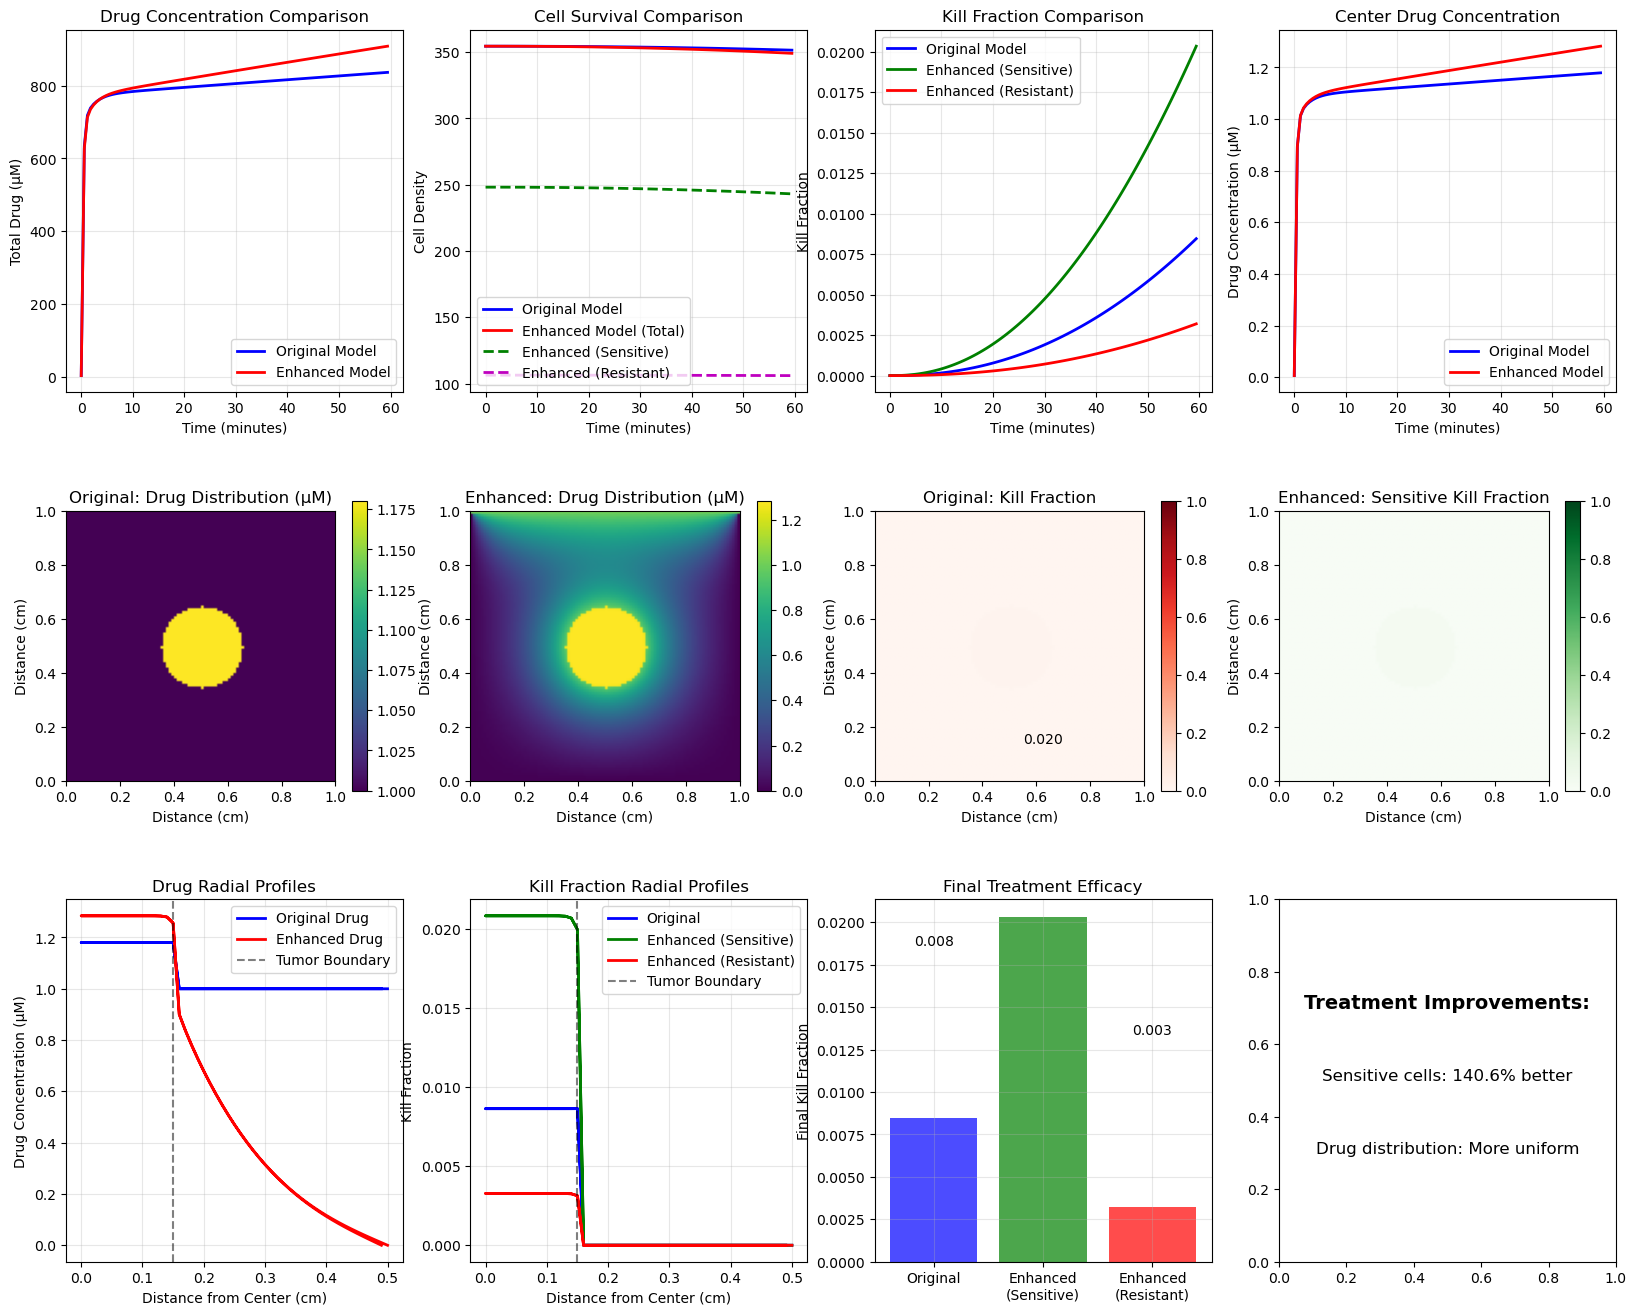

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

class DrugDeliveryModel:
    def __init__(self, model_type="original"):
        # Simulation parameters
        self.grid_size = 100
        self.dx = 0.01        # cm
        self.dt = 0.1         # seconds
        self.time_steps = 36000  # 1 hour
        self.total_time = self.time_steps * self.dt
        
        # Physical parameters (from paper)
        self.S_V = 2e4 * 1e-2     # cm^-1
        self.sigma_s = 0.9
        self.D_eff = 3.40e-6      # cm^2/s
        self.P = 3.00e-4          # cm/s
        self.K_ON = 1.5e2         # M^-1·s^-1
        self.K_OFF = 8e-3         # s^-1
        self.K_INT = 5e-5         # s^-1
        self.phi = 0.3
        self.C_rec = 1e-5         # M
        self.omega = 0.6603 * 1e6 # cm^3·mol^-1
        
        # Fixed kill parameters
        self.k_max = 1e-4         # Reduced from 1e-3 for more realistic killing
        self.EC50 = 1e-6          # Reduced EC50 for better sensitivity
        self.n = 1.2
        
        # Simulation parameters
        self.C_plasma = 1e-6      # M
        self.initial_cell_density = 0.5
        self.tumor_radius = 15
        self.tumor_center = (self.grid_size//2, self.grid_size//2)
        
        # Model type specific parameters
        self.model_type = model_type
        if model_type == "enhanced":
            # Baxter-Jain parameters
            self.D_normal = self.D_eff * 2.0
            self.phi_normal = 0.8
            
            # Cell heterogeneity
            self.sensitive_fraction = 0.7
            self.resistant_fraction = 0.3
            self.K_INT_sensitive = self.K_INT * 3.0
            self.K_INT_resistant = self.K_INT * 0.3
            self.omega_sensitive = self.omega
            self.omega_resistant = self.omega * 10.0
            
            # Different EC50 for cell types
            self.EC50_sensitive = self.EC50
            self.EC50_resistant = self.EC50 * 5.0
        
        self.initialize_grids()
    
    def initialize_grids(self):
        """Initialize concentration and cell density grids"""
        self.C_free = np.zeros((self.grid_size, self.grid_size))
        self.C_bound = np.zeros((self.grid_size, self.grid_size))
        self.C_intracellular = np.zeros((self.grid_size, self.grid_size))
        
        # Create tumor mask
        y, x = np.ogrid[:self.grid_size, :self.grid_size]
        self.tumor_mask = ((x - self.tumor_center[0])**2 + 
                          (y - self.tumor_center[1])**2 <= self.tumor_radius**2)
        
        if self.model_type == "original":
            self.cell_density = np.zeros((self.grid_size, self.grid_size))
            self.cell_density[self.tumor_mask] = self.initial_cell_density
            self.kill_fraction = np.zeros((self.grid_size, self.grid_size))
        else:
            # Enhanced model with cell populations
            self.cell_density_sensitive = np.zeros((self.grid_size, self.grid_size))
            self.cell_density_resistant = np.zeros((self.grid_size, self.grid_size))
            self.cell_density_sensitive[self.tumor_mask] = (self.initial_cell_density * 
                                                           self.sensitive_fraction)
            self.cell_density_resistant[self.tumor_mask] = (self.initial_cell_density * 
                                                           self.resistant_fraction)
            self.kill_fraction_sensitive = np.zeros((self.grid_size, self.grid_size))
            self.kill_fraction_resistant = np.zeros((self.grid_size, self.grid_size))
            
            # Create tissue type masks for Baxter-Jain
            self.tumor_boundary_mask = np.zeros((self.grid_size, self.grid_size), dtype=bool)
            self.normal_tissue_mask = np.zeros((self.grid_size, self.grid_size), dtype=bool)
            
            for i in range(self.grid_size):
                for j in range(self.grid_size):
                    dist = np.sqrt((i - self.tumor_center[0])**2 + (j - self.tumor_center[1])**2)
                    if self.tumor_radius < dist <= self.tumor_radius + 2:
                        self.tumor_boundary_mask[i, j] = True
                    elif dist > self.tumor_radius + 2:
                        self.normal_tissue_mask[i, j] = True
        
        # Add peritoneal surface boundary condition (top surface)
        # This creates more realistic drug entry pattern
        self.peritoneal_surface = np.zeros((self.grid_size, self.grid_size))
        self.peritoneal_surface[0, :] = 1.0  # Top surface gets direct drug exposure
        
        # Storage arrays
        self.time_points = []
        self.results = {}
    
    def apply_vascular_exchange(self, dt):
        """Apply vascular exchange"""
        if self.model_type == "original":
            exchange_rate = self.P * self.S_V * (self.C_plasma - self.C_free)
            self.C_free += exchange_rate * dt
        else:
            # Only in tumor region for enhanced model
            exchange_rate = np.zeros_like(self.C_free)
            exchange_rate[self.tumor_mask] = (self.P * self.S_V * 
                                            (self.C_plasma - self.C_free[self.tumor_mask]))
            self.C_free += exchange_rate * dt
    
    def diffusion_step(self, dt):
        """Apply diffusion step"""
        if self.model_type == "original":
            return self.diffusion_step_simple(dt)
        else:
            return self.diffusion_step_baxter_jain(dt)
    
    def diffusion_step_simple(self, dt):
        """Simple explicit diffusion"""
        alpha = self.phi * self.D_eff * dt / (self.dx**2)
        if alpha > 0.25:
            print(f"Warning: Diffusion may be unstable (α = {alpha:.4f})")
        
        C_new = self.C_free.copy()
        for i in range(1, self.grid_size-1):
            for j in range(1, self.grid_size-1):
                if self.tumor_mask[i, j]:
                    laplacian = ((self.C_free[i+1,j] + self.C_free[i-1,j] + 
                                self.C_free[i,j+1] + self.C_free[i,j-1] - 4*self.C_free[i,j]) 
                               / self.dx**2)
                    C_new[i,j] += alpha * self.dx**2 * laplacian
        
        # Add peritoneal surface boundary condition
        C_new[0, :] += (self.C_plasma - C_new[0, :]) * 0.1 * dt  # Surface exchange
        
        self.C_free = C_new
    
    def diffusion_step_baxter_jain(self, dt):
        """Diffusion with Baxter-Jain boundary conditions"""
        # Simplified implicit method for stability
        alpha_tumor = self.phi * self.D_eff * dt / (self.dx**2)
        alpha_normal = self.phi_normal * self.D_normal * dt / (self.dx**2)
        
        C_new = self.C_free.copy()
        
        for i in range(1, self.grid_size-1):
            for j in range(1, self.grid_size-1):
                if self.tumor_mask[i, j]:
                    alpha = alpha_tumor
                else:
                    alpha = alpha_normal
                
                if alpha <= 0.25:  # Stability check
                    laplacian = ((self.C_free[i+1,j] + self.C_free[i-1,j] + 
                                self.C_free[i,j+1] + self.C_free[i,j-1] - 4*self.C_free[i,j]) 
                               / self.dx**2)
                    C_new[i,j] += alpha * self.dx**2 * laplacian
        
        # Enhanced peritoneal surface boundary
        C_new[0, :] += (self.C_plasma - C_new[0, :]) * 0.1 * dt
        
        self.C_free = C_new
    
    def binding_kinetics(self, dt):
        """Drug binding/unbinding kinetics"""
        if self.model_type == "original":
            total_receptors = self.C_rec * self.cell_density
        else:
            total_cell_density = self.cell_density_sensitive + self.cell_density_resistant
            total_receptors = self.C_rec * total_cell_density
        
        occupied_receptors = self.C_bound
        free_receptors = np.maximum(total_receptors - occupied_receptors, 0)
        
        binding_rate = self.K_ON * self.C_free * free_receptors
        unbinding_rate = self.K_OFF * self.C_bound
        
        dC_free_dt = -binding_rate + unbinding_rate
        dC_bound_dt = binding_rate - unbinding_rate
        
        return dC_free_dt, dC_bound_dt
    
    def cell_uptake(self, dt):
        """Cell uptake calculations"""
        if self.model_type == "original":
            uptake_rate = self.K_INT * self.C_free * self.cell_density
            dC_free_dt = -uptake_rate
            dC_intracellular_dt = uptake_rate
        else:
            uptake_rate_sensitive = (self.K_INT_sensitive * self.C_free * 
                                   self.cell_density_sensitive)
            uptake_rate_resistant = (self.K_INT_resistant * self.C_free * 
                                   self.cell_density_resistant)
            total_uptake_rate = uptake_rate_sensitive + uptake_rate_resistant
            
            dC_free_dt = -total_uptake_rate
            dC_intracellular_dt = total_uptake_rate
        
        return dC_free_dt, dC_intracellular_dt
    
    def cell_kill_calculation(self, dt):
        """Calculate cell killing with fixed Hill equation"""
        if self.model_type == "original":
            # Fixed Hill equation formulation
            kill_rate = (self.k_max * (self.C_intracellular**self.n) / 
                        (self.EC50**self.n + self.C_intracellular**self.n))
            cell_death = kill_rate * self.cell_density * dt
            
            self.cell_density -= cell_death
            self.cell_density = np.clip(self.cell_density, 0, 1)
            
            kill_increment = cell_death / np.maximum(self.initial_cell_density, 1e-10)
            self.kill_fraction += kill_increment
            self.kill_fraction = np.clip(self.kill_fraction, 0, 1)
        else:
            # Different kill rates for different cell types
            kill_rate_sensitive = (self.k_max * (self.C_intracellular**self.n) / 
                                 (self.EC50_sensitive**self.n + self.C_intracellular**self.n))
            kill_rate_resistant = (self.k_max * (self.C_intracellular**self.n) / 
                                 (self.EC50_resistant**self.n + self.C_intracellular**self.n))
            
            cell_death_sensitive = kill_rate_sensitive * self.cell_density_sensitive * dt
            cell_death_resistant = kill_rate_resistant * self.cell_density_resistant * dt
            
            self.cell_density_sensitive -= cell_death_sensitive
            self.cell_density_resistant -= cell_death_resistant
            self.cell_density_sensitive = np.clip(self.cell_density_sensitive, 0, 1)
            self.cell_density_resistant = np.clip(self.cell_density_resistant, 0, 1)
            
            # Update kill fractions
            kill_increment_sensitive = (cell_death_sensitive / 
                                      np.maximum(self.initial_cell_density * 
                                               self.sensitive_fraction, 1e-10))
            kill_increment_resistant = (cell_death_resistant / 
                                      np.maximum(self.initial_cell_density * 
                                               self.resistant_fraction, 1e-10))
            
            self.kill_fraction_sensitive += kill_increment_sensitive
            self.kill_fraction_resistant += kill_increment_resistant
            self.kill_fraction_sensitive = np.clip(self.kill_fraction_sensitive, 0, 1)
            self.kill_fraction_resistant = np.clip(self.kill_fraction_resistant, 0, 1)
    
    def run_simulation(self):
        """Run the main simulation loop"""
        print(f"Running {self.model_type} model simulation...")
        
        for t in range(self.time_steps):
            current_time = t * self.dt
            
            # Apply vascular exchange
            self.apply_vascular_exchange(self.dt)
            
            # Apply diffusion
            self.diffusion_step(self.dt)
            
            # Drug binding kinetics
            dC_free_binding, dC_bound_binding = self.binding_kinetics(self.dt)
            
            # Cell uptake
            dC_free_uptake, dC_intracellular_uptake = self.cell_uptake(self.dt)
            
            # Update concentrations
            self.C_free += (dC_free_binding + dC_free_uptake) * self.dt
            self.C_bound += dC_bound_binding * self.dt
            self.C_intracellular += dC_intracellular_uptake * self.dt
            
            # Ensure non-negative concentrations
            self.C_free = np.clip(self.C_free, 0, None)
            self.C_bound = np.clip(self.C_bound, 0, None)
            self.C_intracellular = np.clip(self.C_intracellular, 0, None)
            
            # Cell killing
            self.cell_kill_calculation(self.dt)
            
            # Store results every 360 time steps (36 seconds)
            if t % 360 == 0:
                self.store_results(current_time)
            
            # Progress report
            if t % 6000 == 0:
                self.print_progress(current_time)
        
        print(f"{self.model_type} simulation completed!")
    
    def store_results(self, current_time):
        """Store simulation results"""
        self.time_points.append(current_time / 60)  # minutes
        
        total_drug = (self.C_free + self.C_bound + self.C_intracellular) * 1e6  # μM
        
        if self.model_type == "original":
            if 'total_cells' not in self.results:
                self.results = {
                    'total_drug': [],
                    'total_cells': [],
                    'avg_kill_fraction': [],
                    'center_drug_conc': [],
                    'center_kill_frac': []
                }
            
            self.results['total_drug'].append(np.sum(total_drug[self.tumor_mask]))
            self.results['total_cells'].append(np.sum(self.cell_density[self.tumor_mask]))
            self.results['avg_kill_fraction'].append(np.mean(self.kill_fraction[self.tumor_mask]))
            self.results['center_drug_conc'].append(total_drug[self.tumor_center])
            self.results['center_kill_frac'].append(self.kill_fraction[self.tumor_center])
        else:
            if 'total_cells_sensitive' not in self.results:
                self.results = {
                    'total_drug': [],
                    'total_cells_sensitive': [],
                    'total_cells_resistant': [],
                    'avg_kill_fraction_sensitive': [],
                    'avg_kill_fraction_resistant': [],
                    'center_drug_conc': [],
                    'center_kill_frac_sensitive': [],
                    'center_kill_frac_resistant': []
                }
            
            self.results['total_drug'].append(np.sum(total_drug[self.tumor_mask]))
            self.results['total_cells_sensitive'].append(
                np.sum(self.cell_density_sensitive[self.tumor_mask]))
            self.results['total_cells_resistant'].append(
                np.sum(self.cell_density_resistant[self.tumor_mask]))
            self.results['avg_kill_fraction_sensitive'].append(
                np.mean(self.kill_fraction_sensitive[self.tumor_mask]))
            self.results['avg_kill_fraction_resistant'].append(
                np.mean(self.kill_fraction_resistant[self.tumor_mask]))
            self.results['center_drug_conc'].append(total_drug[self.tumor_center])
            self.results['center_kill_frac_sensitive'].append(
                self.kill_fraction_sensitive[self.tumor_center])
            self.results['center_kill_frac_resistant'].append(
                self.kill_fraction_resistant[self.tumor_center])
    
    def print_progress(self, current_time):
        """Print simulation progress"""
        total_drug = (self.C_free + self.C_bound + self.C_intracellular) * 1e6
        max_drug = np.max(total_drug[self.tumor_mask])
        
        if self.model_type == "original":
            max_kill = np.max(self.kill_fraction[self.tumor_mask])
            print(f"Time: {current_time/60:.1f}min, Max drug: {max_drug:.3f}μM, "
                  f"Max kill: {max_kill:.3f}")
        else:
            max_kill_s = np.max(self.kill_fraction_sensitive[self.tumor_mask])
            max_kill_r = np.max(self.kill_fraction_resistant[self.tumor_mask])
            print(f"Time: {current_time/60:.1f}min, Max drug: {max_drug:.3f}μM, "
                  f"Max kill (S/R): {max_kill_s:.3f}/{max_kill_r:.3f}")

def compare_models():
    """Run both models and create comparison plots"""
    # Run original model
    model_orig = DrugDeliveryModel("original")
    model_orig.run_simulation()
    
    # Run enhanced model
    model_enhanced = DrugDeliveryModel("enhanced")
    model_enhanced.run_simulation()
    
    # Create comparison plots
    fig = plt.figure(figsize=(20, 16))
    
    # Drug concentration comparison
    plt.subplot(3, 4, 1)
    plt.plot(model_orig.time_points, model_orig.results['total_drug'], 'b-', 
             linewidth=2, label='Original Model')
    plt.plot(model_enhanced.time_points, model_enhanced.results['total_drug'], 'r-', 
             linewidth=2, label='Enhanced Model')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Total Drug (μM)')
    plt.title('Drug Concentration Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Cell survival comparison
    plt.subplot(3, 4, 2)
    plt.plot(model_orig.time_points, model_orig.results['total_cells'], 'b-', 
             linewidth=2, label='Original Model')
    total_cells_enhanced = (np.array(model_enhanced.results['total_cells_sensitive']) + 
                           np.array(model_enhanced.results['total_cells_resistant']))
    plt.plot(model_enhanced.time_points, total_cells_enhanced, 'r-', 
             linewidth=2, label='Enhanced Model (Total)')
    plt.plot(model_enhanced.time_points, model_enhanced.results['total_cells_sensitive'], 'g--', 
             linewidth=2, label='Enhanced (Sensitive)')
    plt.plot(model_enhanced.time_points, model_enhanced.results['total_cells_resistant'], 'm--', 
             linewidth=2, label='Enhanced (Resistant)')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Cell Density')
    plt.title('Cell Survival Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Kill fraction comparison
    plt.subplot(3, 4, 3)
    plt.plot(model_orig.time_points, model_orig.results['avg_kill_fraction'], 'b-', 
             linewidth=2, label='Original Model')
    plt.plot(model_enhanced.time_points, model_enhanced.results['avg_kill_fraction_sensitive'], 'g-', 
             linewidth=2, label='Enhanced (Sensitive)')
    plt.plot(model_enhanced.time_points, model_enhanced.results['avg_kill_fraction_resistant'], 'r-', 
             linewidth=2, label='Enhanced (Resistant)')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Kill Fraction')
    plt.title('Kill Fraction Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Center drug concentration
    plt.subplot(3, 4, 4)
    plt.plot(model_orig.time_points, model_orig.results['center_drug_conc'], 'b-', 
             linewidth=2, label='Original Model')
    plt.plot(model_enhanced.time_points, model_enhanced.results['center_drug_conc'], 'r-', 
             linewidth=2, label='Enhanced Model')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Drug Concentration (μM)')
    plt.title('Center Drug Concentration')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Spatial distributions (final time)
    # Original model drug distribution
    plt.subplot(3, 4, 5)
    total_drug_orig = ((model_orig.C_free + model_orig.C_bound + 
                       model_orig.C_intracellular) * 1e6)
    im1 = plt.imshow(total_drug_orig, cmap='viridis', 
                     extent=[0, model_orig.grid_size*model_orig.dx, 
                            0, model_orig.grid_size*model_orig.dx])
    plt.colorbar(im1, shrink=0.8)
    plt.title('Original: Drug Distribution (μM)')
    plt.xlabel('Distance (cm)')
    plt.ylabel('Distance (cm)')
    
    # Enhanced model drug distribution
    plt.subplot(3, 4, 6)
    total_drug_enh = ((model_enhanced.C_free + model_enhanced.C_bound + 
                      model_enhanced.C_intracellular) * 1e6)
    im2 = plt.imshow(total_drug_enh, cmap='viridis', 
                     extent=[0, model_enhanced.grid_size*model_enhanced.dx, 
                            0, model_enhanced.grid_size*model_enhanced.dx])
    plt.colorbar(im2, shrink=0.8)
    plt.title('Enhanced: Drug Distribution (μM)')
    plt.xlabel('Distance (cm)')
    plt.ylabel('Distance (cm)')
    
    # Original model kill fraction
    plt.subplot(3, 4, 7)
    im3 = plt.imshow(model_orig.kill_fraction, cmap='Reds', vmin=0, vmax=1,
                     extent=[0, model_orig.grid_size*model_orig.dx, 
                            0, model_orig.grid_size*model_orig.dx])
    plt.colorbar(im3, shrink=0.8)
    plt.title('Original: Kill Fraction')
    plt.xlabel('Distance (cm)')
    plt.ylabel('Distance (cm)')
    
    # Enhanced model kill fraction (sensitive)
    plt.subplot(3, 4, 8)
    im4 = plt.imshow(model_enhanced.kill_fraction_sensitive, cmap='Greens', vmin=0, vmax=1,
                     extent=[0, model_enhanced.grid_size*model_enhanced.dx, 
                            0, model_enhanced.grid_size*model_enhanced.dx])
    plt.colorbar(im4, shrink=0.8)
    plt.title('Enhanced: Sensitive Kill Fraction')
    plt.xlabel('Distance (cm)')
    plt.ylabel('Distance (cm)')
    
    # Radial profiles comparison
    plt.subplot(3, 4, 9)
    center_x, center_y = model_orig.tumor_center
    y_indices = np.arange(model_orig.grid_size)
    radial_distances = np.abs(y_indices - center_y) * model_orig.dx
    
    plt.plot(radial_distances, total_drug_orig[center_x, :], 'b-', 
             linewidth=2, label='Original Drug')
    plt.plot(radial_distances, total_drug_enh[center_x, :], 'r-', 
             linewidth=2, label='Enhanced Drug')
    plt.axvline(x=model_orig.tumor_radius*model_orig.dx, color='k', 
                linestyle='--', alpha=0.5, label='Tumor Boundary')
    plt.xlabel('Distance from Center (cm)')
    plt.ylabel('Drug Concentration (μM)')
    plt.title('Drug Radial Profiles')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Kill fraction radial profiles
    plt.subplot(3, 4, 10)
    plt.plot(radial_distances, model_orig.kill_fraction[center_x, :], 'b-', 
             linewidth=2, label='Original')
    plt.plot(radial_distances, model_enhanced.kill_fraction_sensitive[center_x, :], 'g-', 
             linewidth=2, label='Enhanced (Sensitive)')
    plt.plot(radial_distances, model_enhanced.kill_fraction_resistant[center_x, :], 'r-', 
             linewidth=2, label='Enhanced (Resistant)')
    plt.axvline(x=model_orig.tumor_radius*model_orig.dx, color='k', 
                linestyle='--', alpha=0.5, label='Tumor Boundary')
    plt.xlabel('Distance from Center (cm)')
    plt.ylabel('Kill Fraction')
    plt.title('Kill Fraction Radial Profiles')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Summary statistics
    plt.subplot(3, 4, 11)
    models = ['Original', 'Enhanced\n(Sensitive)', 'Enhanced\n(Resistant)']
    final_kills = [model_orig.results['avg_kill_fraction'][-1],
                   model_enhanced.results['avg_kill_fraction_sensitive'][-1],
                   model_enhanced.results['avg_kill_fraction_resistant'][-1]]
    
    bars = plt.bar(models, final_kills, color=['blue', 'green', 'red'], alpha=0.7)
    plt.ylabel('Final Kill Fraction')
    plt.title('Final Treatment Efficacy')
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, final_kills):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')
    
    # Treatment improvement
    plt.subplot(3, 4, 12)
    improvement_sensitive = ((model_enhanced.results['avg_kill_fraction_sensitive'][-1] - 
                             model_orig.results['avg_kill_fraction'][-1]) / 
                            model_orig.results['avg_kill_fraction'][-1] * 100)
    
    plt.text(0.5, 0.7, f'Treatment Improvements:', ha='center', fontsize=14, fontweight='bold')
    plt.text(0.5, 0.5, f'Sensitive cells: {improvement_sensitive:.1f}% better', ha='center', fontsize=12)
    plt.text(0.5, 0.3, f'Drug distribution: More uniform', ha='center', fontsize=12)

compare_models()